In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [79]:
labels_data = pd.read_csv("BasicSurvey(3-6-20).csv")
data = pd.read_csv("FitbitActivity(1-30-20).csv")

numeric_columns = data.select_dtypes(include=['number']).columns
data_grouped = data.groupby('egoid')[numeric_columns].mean()
data_grouped.reset_index(inplace=True, drop=True)
labels_data.reset_index(inplace=True, drop=True)
merged_data = pd.merge(data_grouped, labels_data, on='egoid', how='inner')


# Features and target variable
features = ['lowrangemins', 'fatburnmins', 'cardiomins', 'peakmins',
            'lowrangecal', 'fatburncal', 'cardiocal', 'sedentaryminutes',
            'lightlyactiveminutes', 'fairlyactiveminutes', 'veryactiveminutes',
            'meanrate', 'sdrate', 'steps', 'floors']
target = 'gpa_fa2017'

merged_data_cleaned = merged_data.dropna(subset=features + [target])

X = merged_data_cleaned[features].values
y = merged_data_cleaned[target].values

# Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<ipython-input-79-99b9bb61fc5e>:1: DtypeWarning: Columns (314,391,392,789,791,792,1124,1125,1227,1228,1231,1232,1477,1478,1554,1555,1556,1557,1558,1559,1561,1568,1571,1678,1687,1745,1746,1818,1836,1837,1843,1844,1849,1851,1852,1853,2072,2116,2117,2264,2266,2280,2281,2282,2283,2289,2290,2483,2484,2501,2502,2508,2509,2699,2711,2712,2830) have mixed types. Specify dtype option on import or set low_memory=False.
  labels_data = pd.read_csv("BasicSurvey(3-6-20).csv")


In [80]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
# Training
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,  # Number of epochs
    batch_size=128,  # Batch size
    callbacks=[early_stop],  # Early stopping
    verbose=1  # Show training progress
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 12.1439 - mae: 3.4616 - val_loss: 11.6061 - val_mae: 3.3768
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 11.6599 - mae: 3.3886 - val_loss: 11.0852 - val_mae: 3.2977
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.1343 - mae: 3.3092 - val_loss: 10.5518 - val_mae: 3.2140
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 10.4688 - mae: 3.2015 - val_loss: 10.0087 - val_mae: 3.1261
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10.1986 - mae: 3.1574 - val_loss: 9.4528 - val_mae: 3.0326
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.5797 - mae: 3.0545 - val_loss: 8.8856 - val_mae: 2.9329
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.9604 - mae: 2.9479 - val_loss: 8.3228 - val_mae: 2.8291
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.5849 - mae: 2.8685 - val_loss: 7.7616 - val_mae: 2.7210
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.8622 - mae: 2.

In [82]:
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Mean Absolute Error: {mae:.2f}")

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error: 0.75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Mean Squared Error: 0.83
R² Score: -4.61


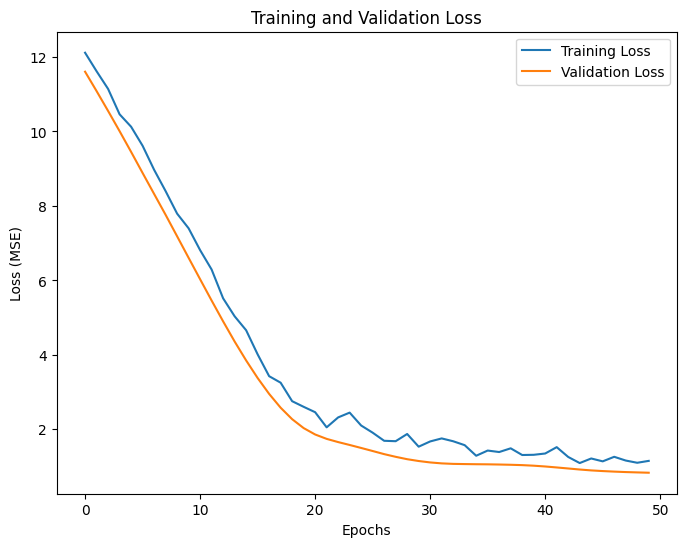

In [83]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


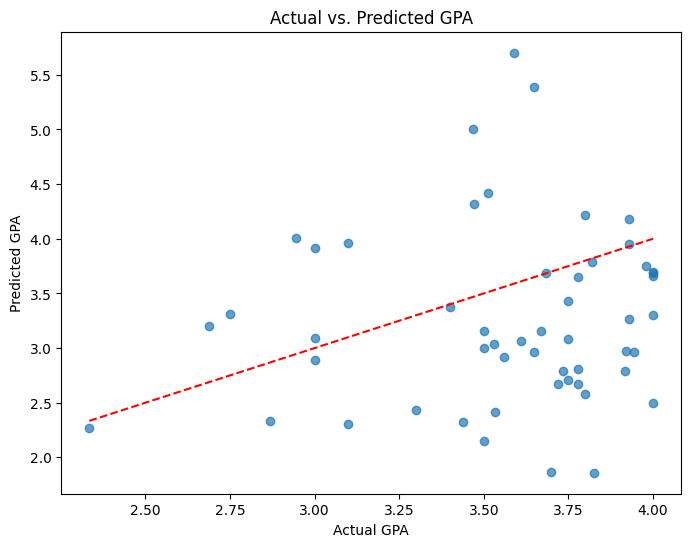

In [84]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs. Predicted GPA")
plt.xlabel("Actual GPA")
plt.ylabel("Predicted GPA")
plt.show()

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = merged_data_cleaned[features + [target]].corr()

# Extract correlation of features with the target variable (GPA)
feature_correlations = correlation_matrix[target].drop(target)

# Sort by absolute value to identify the strongest relationships
feature_correlations = feature_correlations.abs().sort_values(ascending=False)

# Print the feature correlations
print("Feature Correlations with GPA:")
print(feature_correlations)


Feature Correlations with GPA:
meanrate                0.174807
sdrate                  0.162692
floors                  0.151302
fairlyactiveminutes     0.102322
veryactiveminutes       0.090690
fatburnmins             0.070424
lowrangemins            0.067537
cardiocal               0.062111
sedentaryminutes        0.055027
cardiomins              0.051806
lowrangecal             0.033942
steps                   0.024353
peakmins                0.011308
fatburncal              0.010275
lightlyactiveminutes    0.008124
Name: gpa_fa2017, dtype: float64


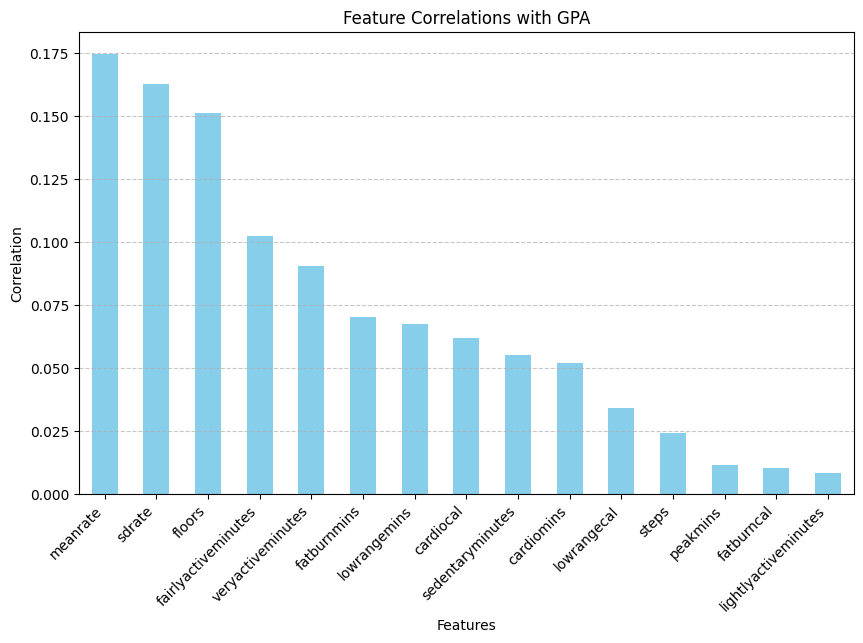

In [100]:
plt.figure(figsize=(10, 6))
feature_correlations.plot(kind='bar', color='skyblue')
plt.title("Feature Correlations with GPA")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

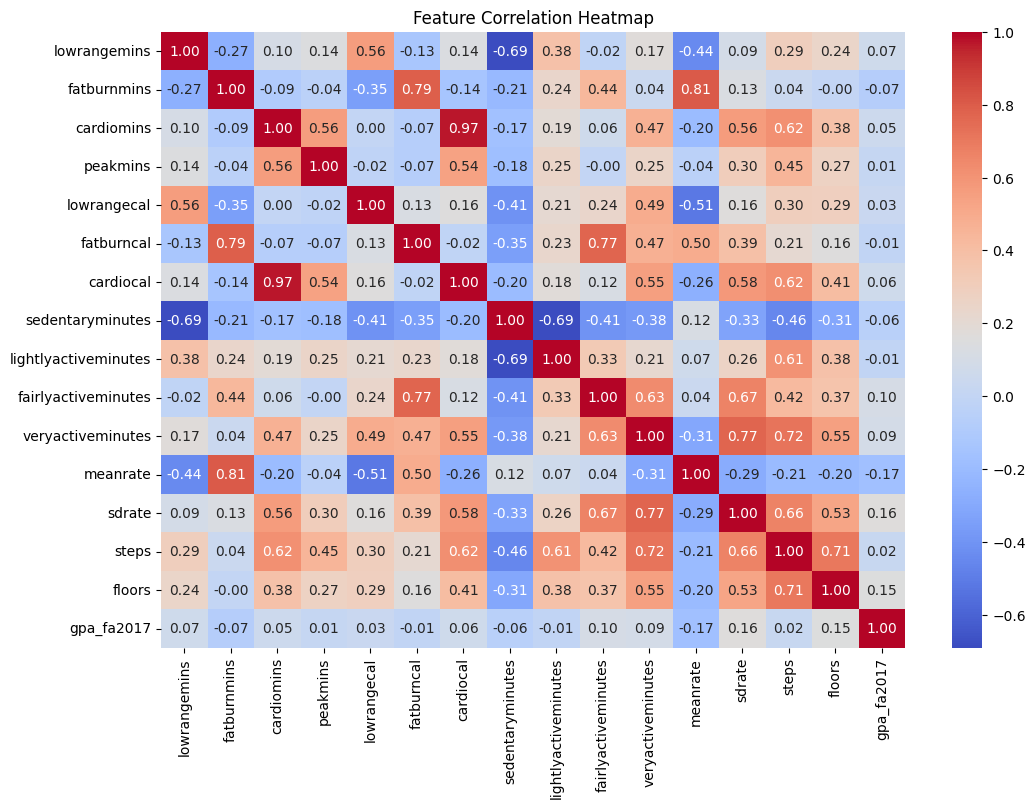

In [101]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()